In [1]:
from scipy.sparse import dok_matrix
import sys
sys.path.insert(0, "/Users/simon/software/devel/farkas-tool")
import switss
from switss.model import MDP, ReachabilityForm
from switss.solver import MILP, LP
from switss.problem import MILPExact, Subsystem, QSHeur
from switss.utils import InvertibleDict
from switss.certification import generate_farkas_certificate, check_farkas_certificate

In [2]:
def print_results(results):
    print("-- results --")
    for idx, r in enumerate(results):
        print("subsys states:" + str(int(r.subsystem.subsystem_mask.sum()))  +", value: " + str(r.value))

In [3]:
def print_result(res):
    print("subsys states:" + str(int(res.subsystem.subsystem_mask.sum())) +", value: " + str(res.value))

In [4]:
index_by_state_action = {(0,0) : 0, (0,1) : 1, (1,0) : 2, (2,0) : 3, (3,0) : 4, (4,0) : 5, (5,0) : 6, (6,0) : 7, (7,0) : 8}


P = [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
     [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
     [0.0, 0.0, 0.6, 0.0, 0.0, 0.0, 0.2, 0.2],
     [0.0, 0.0, 0.0, 0.7, 0.0, 0.0, 0.0, 0.3],
     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
     [0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5],
     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]


label_to_states = {    "target" : {6},
                       "fail" : {7},
                       "init" : {0},
                       "blue" : {1,2,3},
                       "green"  : {4},
                       "brown" : {5}
                  }

mc = MDP(P,index_by_state_action,dict([]),label_to_states)
mc.save("ex_mdp")

('ex_mdp.tra', 'ex_mdp.lab')

A DTMC or MDP can be loaded from a file containing its transition matrix (in the .tra,.lab format) or from a model specified in the PRISM guarded command language.
We first load an example MDP:

In [5]:
mc = MDP.from_file(
    "ex_mdp.lab", "ex_mdp.tra")

The following command renders the MDP:

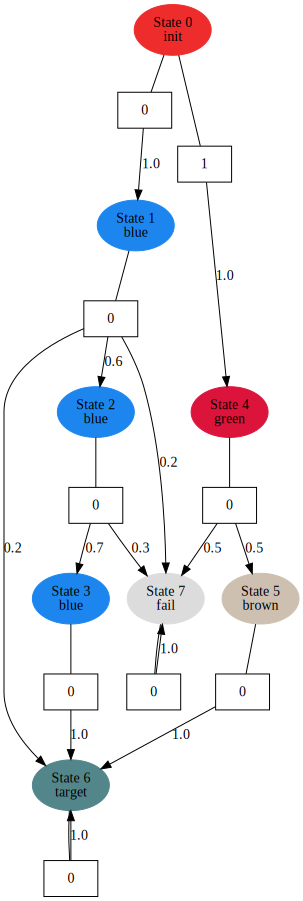

In [6]:
mc.digraph()

The first step to apply the algorithms for computing small witnesses is to transform the MDP into a *reachability form* (RF).
An RF is constructed from an DTMC or MDP and labels specifying an initial state (where only a single state should be labeled) and a set of target states.
The method *reduce* performs forward (from the intial state) and backward (from the target states) reachability queries and removes all unncessary states.
It also adds a new, distinguished target state, which gets an incomming edge from each previous target.

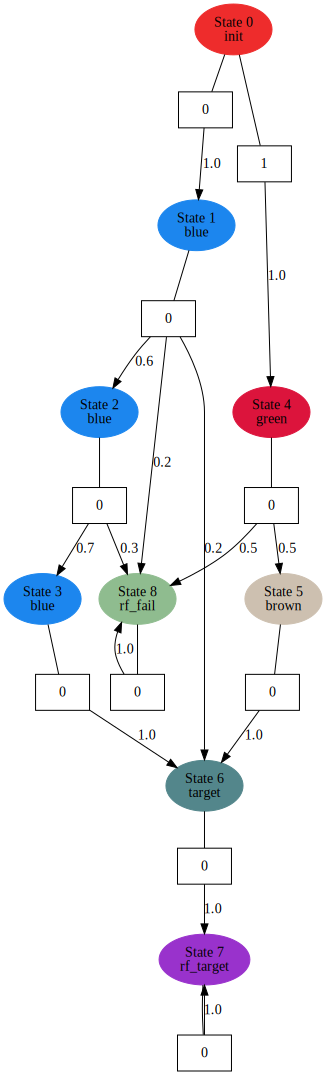

In [7]:
rf,_,_ = ReachabilityForm.reduce(
    mc,"init","target")
rf.system.digraph()

# Certification 

We now demonstrate how Farkas certificates can be generated (by *generate_farkas_certificate*) and verified (by *check_farkas_certificate*).
These methods take an RF, and a specification of the threshold property that should be certified.
We first generate two certificates using two different solvers, and then verify that they are valid:

In [8]:
cert1 = generate_farkas_certificate(
    rf,"max",">=",0.55,solver="cbc")
cert2 = generate_farkas_certificate(
    rf,"max",">=",0.55,solver="glpk")

In [9]:
check_farkas_certificate(
    rf,"max",">=",0.55,cert1)

True

In [10]:
check_farkas_certificate(
    rf,"max",">=",0.55,cert2)

True

If the threshold property is not satisfied by the model, no Farkas certificate can be produced.

In [11]:
fark_cert = generate_farkas_certificate(
    rf,"min",">=",0.55,solver="cbc")

Property is not satisfied!


# Witnessing subsystems

We now turn to the computation of witnessing subsystems, where we first cover the methods for exactly minimizing the number of states for a given threshold property.
In the context of witnessing subsystems, we only consider lower-bounded threshold properties, as reachability probabilities decrease in subsystems.

## minimal WS

The class *MILPExact* (which is a special kind of *ProblemFormulation*) is used to specify queries for exact minimization of an RF for a given threshold property.
It is initialised by specifying the *mode* (min or max) and the solver that should be used.

In [12]:
milp_exact_max = MILPExact(
    "max",solver="cbc")

The *solve* method now takes an RF and a threshold, constructs the MILP and solves it by calling the specified solver.

In [13]:
res = milp_exact_max.solve(rf,0.1)

If successull, the result will contain a subsystem that can also be graphically rendered:

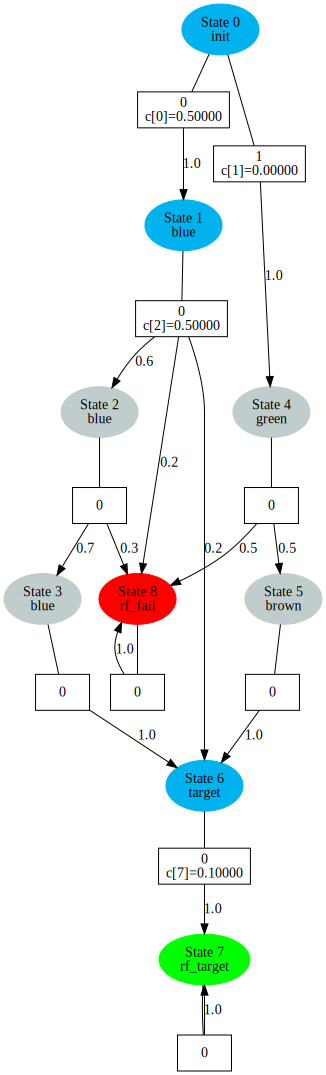

In [14]:
res.subsystem.digraph()

If we increase the threshold to $0.3$, the best choice is not to include only the upper-branch of the MDP (which guarantees a probability of $0.5$ to reach the target).

In [15]:
res = milp_exact_max.solve(rf,0.3)

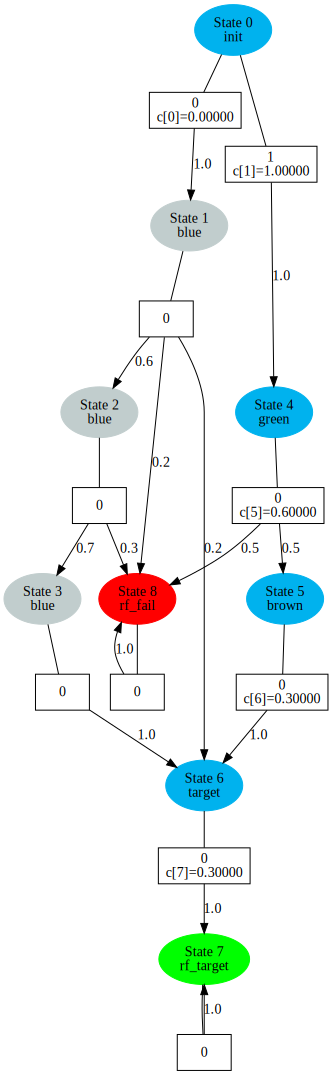

In [16]:
res.subsystem.digraph()

Increasing the threshold to above $0.5$ makes the lower branch better again, although all three states now have to be included in the subsystem.

In [17]:
res = milp_exact_max.solve(rf,0.56)

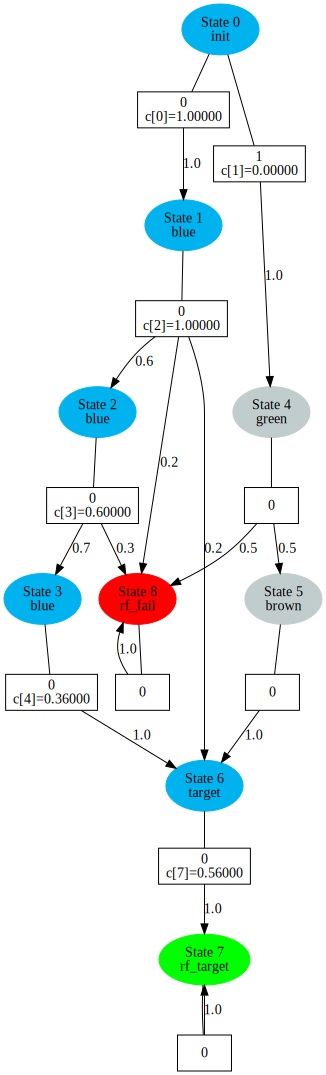

In [18]:
res.subsystem.digraph()

We now consider witness for minimal reachability. Such a witness needs to ensure that the threshold is met by *all* possible schedulers. For $0.1$, it is enough to include the first state in the lower branch, but for $0.3$ already all states have to be included.

In [19]:
milp_exact_min = MILPExact(
    "min",solver="cbc")

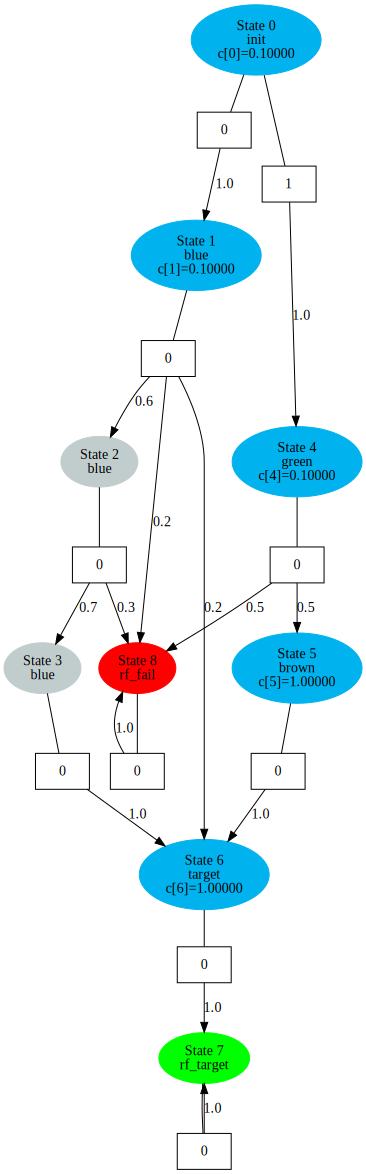

In [20]:
res = milp_exact_min.solve(rf,0.1)
res.subsystem.digraph()

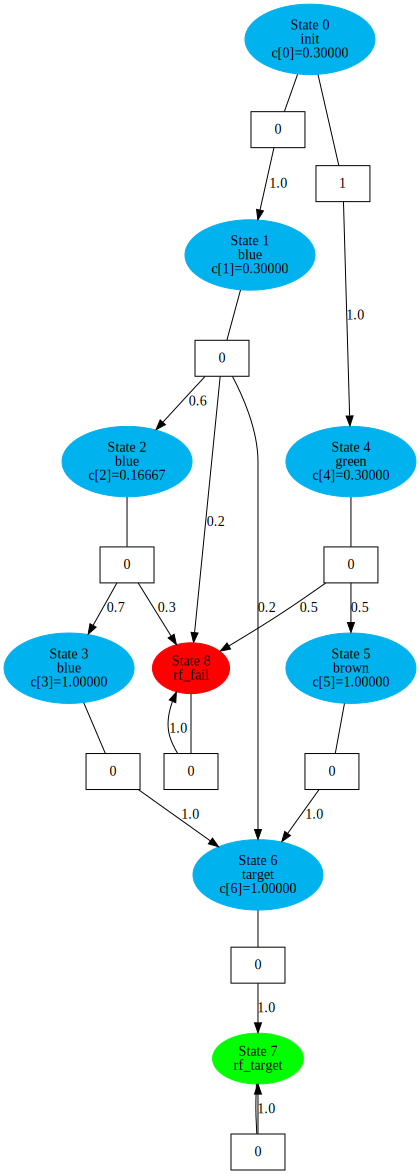

In [21]:
res = milp_exact_min.solve(rf,0.3)
res.subsystem.digraph()

## Heuristics

The counterpart of *MILPExact* for the heuristc computations is *QSHeur*.
As it is an iterative heuristic, we can use the method *solveiter* to return an iterator over the results.
In this case, all three iterations return the same subsystem, which, however is not optimal (compare for the results of the exact query for maximum probabilities and threshold $0.1$).

In [22]:
qs_max_heur1 = QSHeur(
    "max",solver="cbc",iterations=3)
results = list(
    qs_max_heur1.solveiter(rf,0.1))
print_results(results)

-- results --
subsys states:5, value: 5
subsys states:5, value: 5
subsys states:5, value: 5


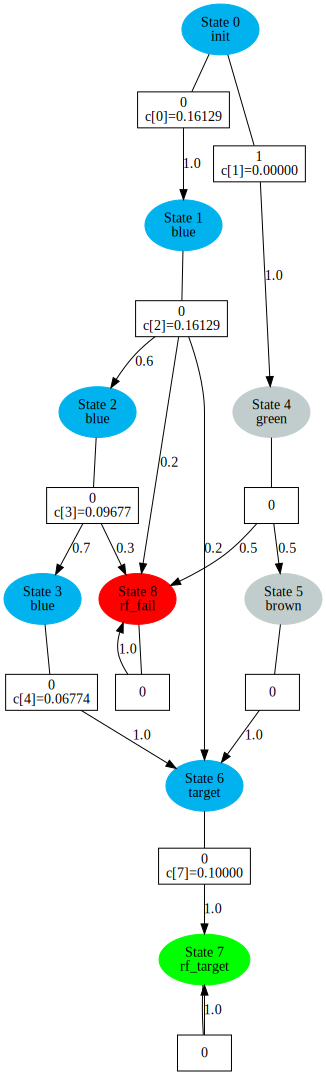

In [23]:
results[2].subsystem.digraph()

The corresponding computation for minimum probabilities improves after the first iteration and returns the optimal witness.

In [24]:
qs_min_heur = QSHeur(
    "min",solver="cbc")
results = list(
    qs_min_heur.solveiter(rf,0.1))
print_results(results)

-- results --
subsys states:7, value: 7
subsys states:5, value: 5
subsys states:5, value: 5


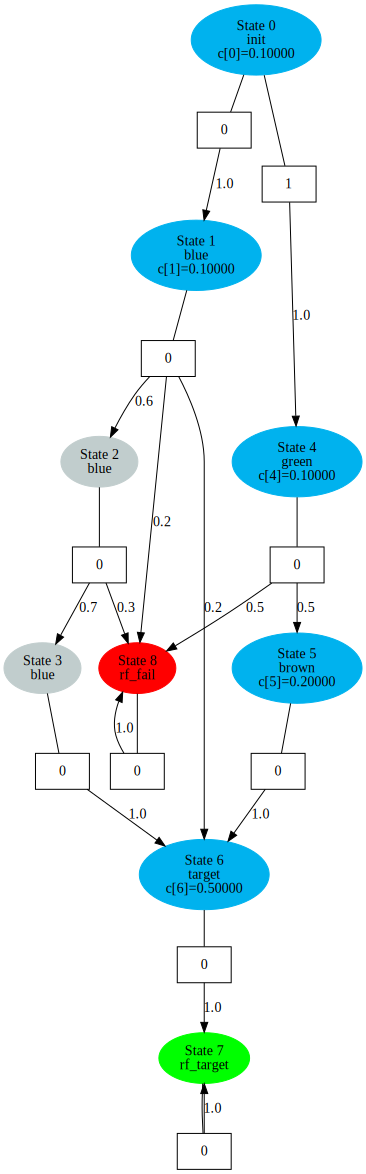

In [25]:
results[2].subsystem.digraph()

## Taking labels into account

Now suppose that we do not want to minimize the amount of states present in the subsystem, but the amounts of *colors* that it includes.
That is, the lower branch counts as one, as it only includes one color, while the upper branch counts two although it has a state less.
We specify that this optimization objective by using the *labels* parameter of the *solve* method.

In [26]:
milp_exact_labels = MILPExact(
    "max",solver="cbc",)
result_labels = milp_exact_labels.solve(
    rf,0.3,labels=["blue","green","brown"])
print_result(result_labels)

subsys states:5, value: 1.0


Now, for max and threshold $0.3$, taking the lower branch is optimal, in contrast to when minimizing the total amount of states.
The value of this subsystem is one, as it only includes one of the colors specified as labels.

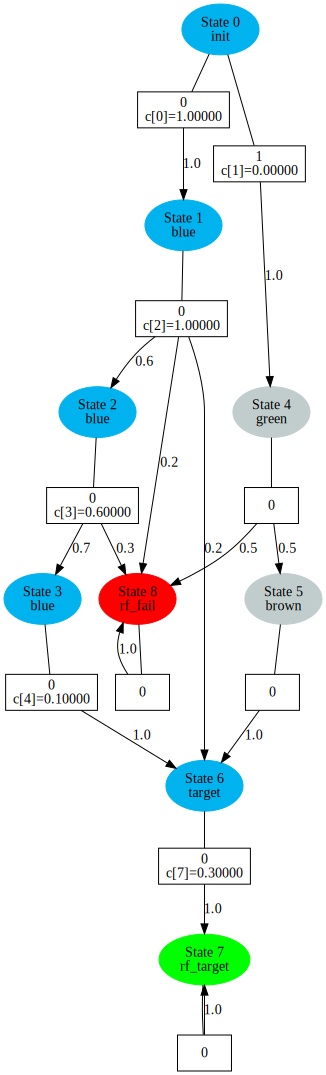

In [27]:
result_labels.subsystem.digraph()